#Boston Harbor water temperature

In [1]:
import pandas as pd
import urllib2
import numpy as np
import matplotlib.pyplot as plt, mpld3
import datetime as dt
%matplotlib inline

In [2]:
# Use ERDDAP's built-in relative time functionality to get last 48 hours:
start='now-3days'
stop='now'
# or specify a specific period:
#start = '2015-01-25T00:00:00Z'
#stop =  '2015-01-30T00:00:00Z'
start = '2014-06-01T00:00:00Z'
stop = '2014-09-01T16:00:00Z'

##Obtain NDBC buoy 44013 data from ERDDAP

In [3]:
dataset_url = 'http://www.neracoos.org/erddap/tabledap/cwwcNDBCMet.csv?station,time,atmp,wtmp,wspu,wspv&station=%2244013%22&time>=2014-06-01T00:00:00Z&time<=2014-09-01T00:00:00Z'

In [4]:
df = pd.read_csv(dataset_url, parse_dates=True, index_col='time', skiprows=[1])
df.to_csv('Dataset.csv')
#df = pd.read_csv(dataset_file, parse_dates=True, index_col='time', skiprows=[1])
df= df.resample(rule='H', how='mean')
df = df.rename(columns={'wtmp':'44013'})

df['44013']=32.+df['44013']*9./5.
df = df.tz_localize('UTC');

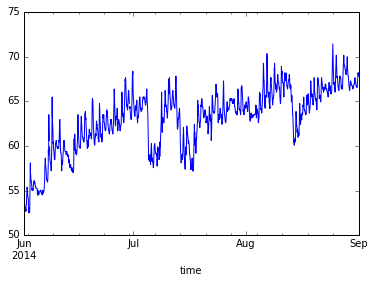

In [5]:
df['44013'].plot()

## Read Deer Island pier data from MWRA CSV file

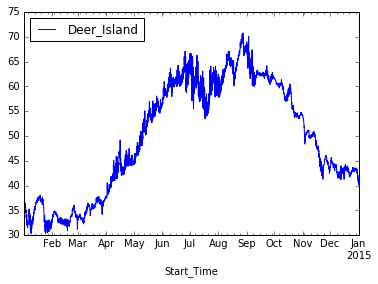

In [6]:
url='/usgs/data2/notebook/data/Pier_Ocean_Temp.txt'
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%y %H:%M')
df2 = pd.read_csv(url, parse_dates=True, index_col='Start_Time', 
                  date_parser=dateparse,skiprows=[0,1,2])
df2 = df2.rename(columns={'Deg_F':'Deer_Island'})
df2 = df2.tz_localize('EST');
df2 = df2.tz_convert('UTC');

df2.plot();


## Read MWRA Harbor Sampling Data (Station 65) from CSV

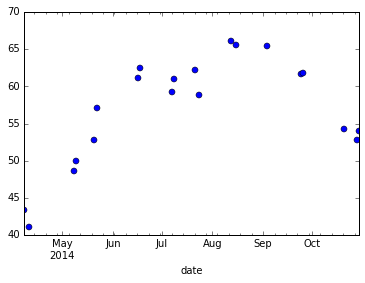

In [7]:
url='/usgs/data2/notebook/data/mwra_station_65.csv'
df3 = pd.read_csv(url, parse_dates=True, index_col=0, 
                  skiprows=1,names=['date','depth','sta65'])
#df2 = df2.rename(columns={'Deg_F':'Deer_Island'})

# the following line turns out to be necessary to avoid Pandas 
# autoformatting from screwing up the plot. 
# https://github.com/pydata/pandas/issues/9524#issuecomment-75099802

df3= df3.resample(rule='H', how='mean')
# convert to F
df3['sta65']=32.+df3['sta65']*9./5.
df3 = df3.tz_localize('America/New_York');
df3 = df3.tz_convert('UTC');
df3['sta65'].plot(marker='o',linestyle='None');

## Inspect data

In [8]:
df.head(5)

,station,atmp,44013,wspu,wspv
time,,,,,
2014-06-01 00:00:00+00:00,44013,11.3,53.96,0.0,-3.7
2014-06-01 01:00:00+00:00,44013,10.8,53.96,1.2,-3.5
2014-06-01 02:00:00+00:00,44013,11.3,53.96,1.3,-2.5
2014-06-01 03:00:00+00:00,44013,11.5,53.78,2.8,-3.8
2014-06-01 04:00:00+00:00,44013,11.6,53.42,2.2,-3.4


In [9]:
df2.head(5)

,End_Time,Deer_Island
Start_Time,,
2014-01-01 05:00:00+00:00,1/1/14 1:00,36.0
2014-01-01 06:00:00+00:00,1/1/14 2:00,35.9
2014-01-01 07:00:00+00:00,1/1/14 3:00,35.8
2014-01-01 08:00:00+00:00,1/1/14 4:00,35.6
2014-01-01 09:00:00+00:00,1/1/14 5:00,35.6


In [10]:
df3.head(5)

,depth,sta65
date,,
2014-04-07 14:00:00+00:00,0.1,43.394
2014-04-07 15:00:00+00:00,NaN,NaN
2014-04-07 16:00:00+00:00,NaN,NaN
2014-04-07 17:00:00+00:00,NaN,NaN
2014-04-07 18:00:00+00:00,NaN,NaN


## Join dataframes together

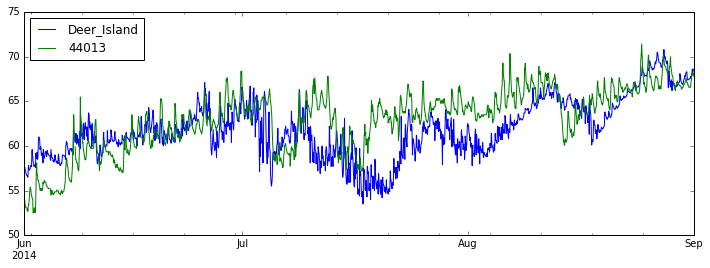

In [11]:
new = pd.DataFrame(df2['Deer_Island']).join(df['44013'], how='inner');
new.plot(legend=True, figsize=(12,4));

## Add discrete water temperature samples 

In [12]:
new.plot(legend=True, figsize=(12,4))
ax=df3['sta65'].plot(marker='o', linestyle='None',legend=True)
ax.set_xlim([dt.date(2014, 6, 1), dt.date(2014, 9, 1)])
ax.set_ylim([50,72]);
mpld3.display()

In [13]:
new[start:stop].plot(legend=True, figsize=(12,4))
ax=df3['sta65'][start:stop].plot(marker='o', linestyle='None',legend=True)
mpld3.display()

In [14]:
import pyugrid
import netCDF4
#NECOFS MassBay forecast
#model='NECOFS-Mbay'
#url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'
# NECOFS MassBay archive
url='http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/archives/necofs_mb'
ug = pyugrid.UGrid.from_ncfile(url)

In [15]:
lon = ug.nodes[:,0]
lat = ug.nodes[:,1]
nv = ug.faces[:]

In [16]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

In [17]:
nc = netCDF4.Dataset(url)
ncv = nc.variables
# Get desired time step  
time_var = ncv['time']
print 'number of time steps:',len(time_var)
dt_start = dt.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ")
dt_stop = dt.datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ")

istart = netCDF4.date2index(dt_start,time_var,select='nearest')
istop = netCDF4.date2index(dt_stop,time_var,select='nearest')


start_time = netCDF4.num2date(time_var[istart],time_var.units)
stop_time = netCDF4.num2date(time_var[istop],time_var.units)
print 'start time:',start_time.strftime('%Y-%b-%d %H:%M')
print 'stop time:',stop_time.strftime('%Y-%b-%d %H:%M')

number of time steps: 34656
start time: 2014-Jun-01 00:00
stop time: 2014-Sep-01 16:01


In [18]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Sta65,             42.336040, -70.980707
DeerPier,     42.346814, -70.959720
b44013, 42.346, -70.651
'''

In [19]:
# Create a Pandas DataFrame
from StringIO import StringIO
obs = pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station')

-c:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


In [20]:
# find closest NECOFS nodes to station locations
obs['0-Based Index'] = nearxy(lon,lat,obs['Lon'],obs['Lat'])

In [21]:
obs

,Lat,Lon,0-Based Index
Station,,,
Sta65,42.336040,-70.980707,66316
DeerPier,42.346814,-70.959720,58598
b44013,42.346000,-70.651000,12079


In [22]:
# get all time steps of surface temperature from each station
nsta=len(obs)
ilayer=0  # surface layer
nt=len(np.arange(istart,istop))
jd = netCDF4.num2date(time_var[istart:istop],time_var.units)
z = np.ones((len(jd),nsta))
for i in range(nsta):
    z[:,i] = ncv['temp'][istart:istop,0,obs['0-Based Index'][i]]

In [23]:
z=32.+z*9./5.


In [24]:
# make a DataFrame out of the interpolated time series at each location
tvals=pd.DataFrame(z,index=jd,columns=obs.index)

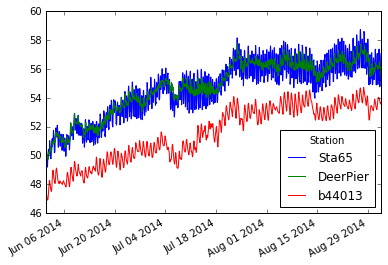

In [25]:
tvals.plot()

In [39]:
a = tvals['Sta65'][0:100].values.reshape(25,4)

In [40]:
a.shape

(25, 4)

In [37]:
b = a.reshape(25,4)

In [38]:
b.shape

(25, 4)